In [1]:
# Tech
tech_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

# Biotech
biotech_tickers = ['JNJ', 'LLY', 'NVO', 'MRK', 'RHHBY']

# Industrial
industrial_tickers = ['DOW', 'GE', 'F', 'UNP', 'SO']

# Healthcare
healthcare_tickers = ['PFE', 'ABBV', 'CVS', 'AMGN', 'UNH']

# Cryptocurrencies
crypto_tickers = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA']

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf
#import riskfolio.RiskFunctions as rk
import warnings

warnings.filterwarnings("ignore")


# List of assets
assets = tech_tickers

# Downloading the data
data = yf.download(assets, period='10y')
data = data.loc[:,('Close')]
ret1 = data.pct_change().dropna()
ret = pd.DataFrame(ret1)

[*********************100%***********************]  5 of 5 completed


In [3]:
n = ret.shape[0]

Risk_norm = {}
for i in assets:
    Risk_norm[i] = {'VaR':[], 'CVaR': [], 'EVaR': []}

window = 250 * 1
alpha = 0.05

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        z = st.norm.ppf(1 - alpha)
        mu, sigma = st.norm.fit(X)
        Risk_norm[j]['VaR'].append(mu - z * sigma)
        Risk_norm[j]['CVaR'].append(mu - sigma * st.norm.pdf(z) / alpha)
        Risk_norm[j]['EVaR'].append(mu - sigma * np.sqrt(-2 * np.log(alpha)))

for i in assets:
    Risk_norm[i] = pd.DataFrame(Risk_norm[i], index=ret.index[window:])

[]

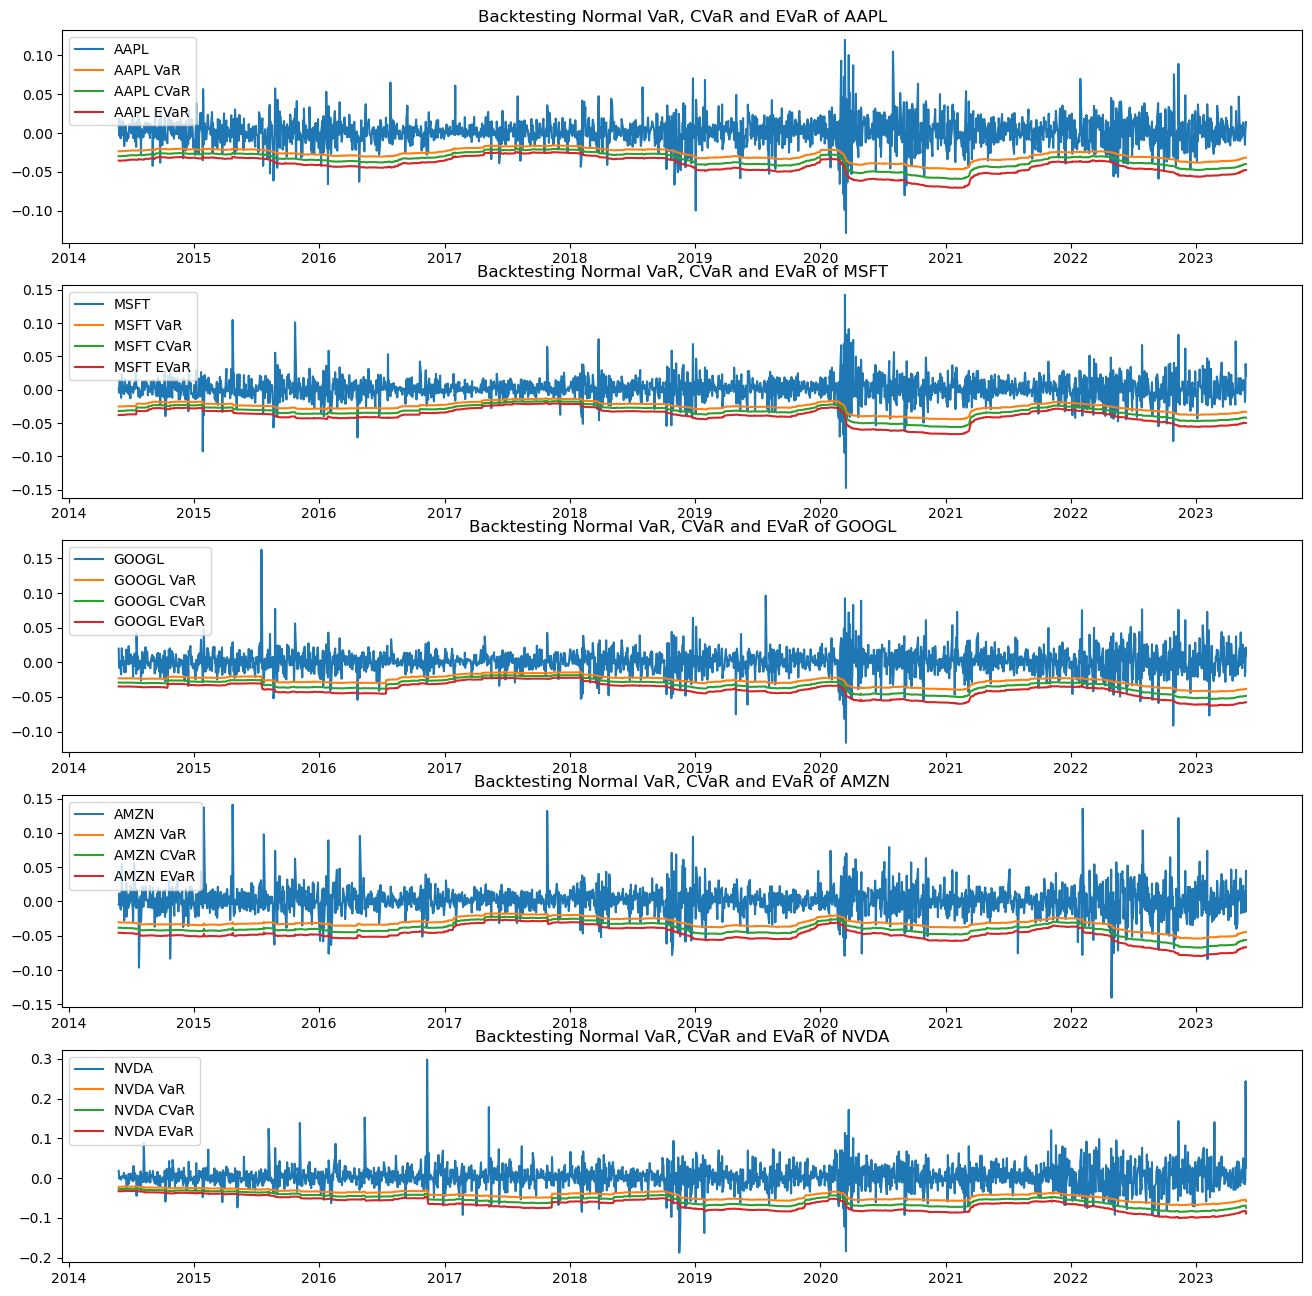

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_norm[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_norm[assets[i]]['CVaR'], label=assets[i] + ' CVaR')
    ax[i].plot(Risk_norm[assets[i]]['EVaR'], label=assets[i] + ' EVaR')
    ax[i].legend()
    ax[i].set_title('Backtesting Normal VaR, CVaR and EVaR of ' + assets[i])

plt.plot()

In [5]:
def bern_test(p, v):
    # Compute the length of the binary vector
    lv = len(v)
    
    # Compute the sum of successes in the binary vector
    sv = sum(v)
    
    # Compute the terms of the Bernoulli test statistic
    al = np.log(p) * sv + np.log(1 - p) * (lv - sv)
    bl = np.log(sv / lv) * sv + np.log(1 - sv / lv) * (lv - sv)
    
    # Calculate the test statistic
    return (-2 * (al - bl))


def ind_test(V):
    # Compute the length of the binary vector
    T = len(V)
    
    # Initialize a matrix to store the combinations of adjacent values
    J = np.full([T, 4], 0)
    
    # Compute the combinations of adjacent values
    for i in range(1, len(V) - 1):
        J[i, 0] = (V[i - 1] == 0) & (V[i] == 0)
        J[i, 1] = (V[i - 1] == 0) & (V[i] == 1)
        J[i, 2] = (V[i - 1] == 1) & (V[i] == 0)
        J[i, 3] = (V[i - 1] == 1) & (V[i] == 1)
    
    # Count the occurrences of each combination
    V_00 = sum(J[:, 0])
    V_01 = sum(J[:, 1])
    V_10 = sum(J[:, 2])
    V_11 = sum(J[:, 3])
    
    # Calculate the probabilities of each combination
    p_00 = V_00 / (V_00 + V_01)
    p_01 = V_01 / (V_00 + V_01)
    p_10 = V_10 / (V_10 + V_11)
    p_11 = V_11 / (V_10 + V_11)
    
    # Calculate the estimated probability
    hat_p = (V_01 + V_11) / (V_00 + V_01 + V_10 + V_11)
    
    # Compute the terms of the independence test statistic
    al = np.log(1 - hat_p) * (V_00 + V_10) + np.log(hat_p) * (V_01 + V_11)
    bl = np.log(p_00) * V_00 + np.log(p_01) * V_01 + np.log(p_10) * V_10 + np.log(p_11) * V_11
    
    # Calculate the test statistic
    return (-2 * (al - bl))


In [6]:
keys = ['Failure Ratio VaR', 
        'Failure Ratio CVaR',
        'Failure Ratio EVaR',
        'Bernoulli Test VaR stat',
        'Bernoulli Test VaR p-value',
        'Bernoulli Test CVaR stat',
        'Bernoulli Test CVaR p-value',
        'Bernoulli Test EVaR stat',
        'Bernoulli Test EVaR p-value',
        'Independent Test VaR stat',
        'Independent Test VaR p-value',
        'Independent Test CVaR stat',
        'Independent Test CVaR p-value',
        'Independent Test EVaR stat',
        'Independent Test EVaR p-value']

Stats_norm = {}
    
for i in assets:
    Stats_norm[i] = {}
    for j in keys:
        Stats_norm[i][j] = []

for i in Stats_norm.keys():
    for j in Risk_norm[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_norm[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_norm[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_norm[i]['Failure Ratio ' + j].append(H/T)
        Stats_norm[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_norm[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_norm[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_norm[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_norm[i] = pd.DataFrame(Stats_norm[i]).T
    Stats_norm[i].columns = [i]
    a = pd.concat([a, Stats_norm[i]], axis=1)

Stats_norm = a
display(Stats_norm)

,AAPL,MSFT,GOOGL,AMZN,NVDA
Failure Ratio VaR,0.055996,0.053351,0.054674,0.048060,0.054233
Failure Ratio CVaR,0.029101,0.031305,0.030864,0.027337,0.024250
Failure Ratio EVaR,0.018959,0.020723,0.019841,0.017637,0.014550
Bernoulli Test VaR stat,1.655510,0.525170,1.013560,0.181950,0.833530
Bernoulli Test VaR p-value,0.198210,0.468640,0.314050,0.669700,0.361250
Bernoulli Test CVaR stat,24.388010,19.138670,20.128730,29.146970,38.774110
Bernoulli Test CVaR p-value,0.000000,0.000010,0.000010,0.000000,0.000000
Bernoulli Test EVaR stat,59.679590,52.032860,55.765510,65.909220,82.292220
Bernoulli Test EVaR p-value,0.000000,0.000000,0.000000,0.000000,0.000000
Independent Test VaR stat,13.732170,13.870420,2.514860,7.279890,8.891410


The analysis of the numbers reveals important insights about the performance and reliability of the risk models applied to the selected assets.

Failure Ratio:

The failure ratio represents the percentage of observations in which the risk models (VaR, CVaR, EVaR) failed to capture the actual losses.
Lower failure ratios indicate better performance, as it implies that the risk models accurately estimated the downside risk.
Across the assets, the failure ratios vary, indicating differences in the performance of the risk models for each asset. For example, AAPL has a relatively low failure ratio for VaR, CVaR, and EVaR, suggesting that the risk models perform well for AAPL.
The highest failure ratios are observed for GOOGL and MSFT, indicating a higher frequency of failures in capturing losses for these assets.

Bernoulli Test:

The Bernoulli test assesses the goodness-of-fit of the risk models by comparing the observed failure patterns to the expected patterns.
The test statistics and p-values provide insights into the deviation of the observed patterns from the expected patterns.
Lower p-values indicate a significant deviation, suggesting that the observed failure patterns differ from what is expected by the risk models.
For example, in the case of AAPL, the Bernoulli test p-values for VaR, CVaR, and EVaR are relatively high, indicating a closer alignment between the observed and expected failure patterns.
On the other hand, MSFT and GOOGL exhibit lower p-values, indicating a significant deviation in the observed failure patterns from the expected patterns.

Independent Test:

The independent test examines the serial independence of the risk models' failures, determining whether the failures exhibit any serial dependence or occur randomly.
The test statistics and p-values indicate the presence of serial dependence in the failure patterns.
Lower p-values suggest a higher likelihood of serial dependence, indicating that the failures of the risk models are not independent.
In this analysis, several assets, such as AAPL and NVDA, have relatively low p-values for the independent test, suggesting a certain degree of serial dependence in the failure patterns.
It is worth noting that for some assets, the independent test statistics and p-values are not available (NaN), indicating the need for further investigation or potential limitations in the analysis.
Overall, the analysis highlights the performance variations among the different risk models and assets. It provides insights into the strengths and weaknesses of the risk models in capturing downside risk, as well as the presence of serial dependence and deviations from expected failure patterns. These findings are essential for evaluating the reliability and effectiveness of the risk models in managing and monitoring the selected assets' risk profiles.

numpy>=1.18.0

scipy>=1.1.0

pandas>=1.0.0

matplotlib>=3.5.0

cvxpy>=1.3.1

scikit-learn>=1.0.0

statsmodels>=0.10.1

arch>=4.15

xlsxwriter>=1.3.7

networkx>=2.5.1

astropy>=4.3.1 (if there are problems check astropy installation instructions)

pybind11>=2.10.1

In [8]:
import riskfolio as rk
n = ret.shape[0]

Risk_hist = {}
for i in assets:
    Risk_hist[i] = {'VaR':[], 'CVaR': [], 'EVaR': []}

window = 250 * 1
alpha = 0.05

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        Risk_hist[j]['VaR'].append(-rk.VaR_Hist(X, alpha=alpha))
        Risk_hist[j]['CVaR'].append(-rk.CVaR_Hist(X, alpha=alpha))
        Risk_hist[j]['EVaR'].append(-rk.EVaR_Hist(-X, alpha=alpha)[0])

for i in assets:
    Risk_hist[i] = pd.DataFrame(Risk_hist[i], index=ret.index[window:])

[]

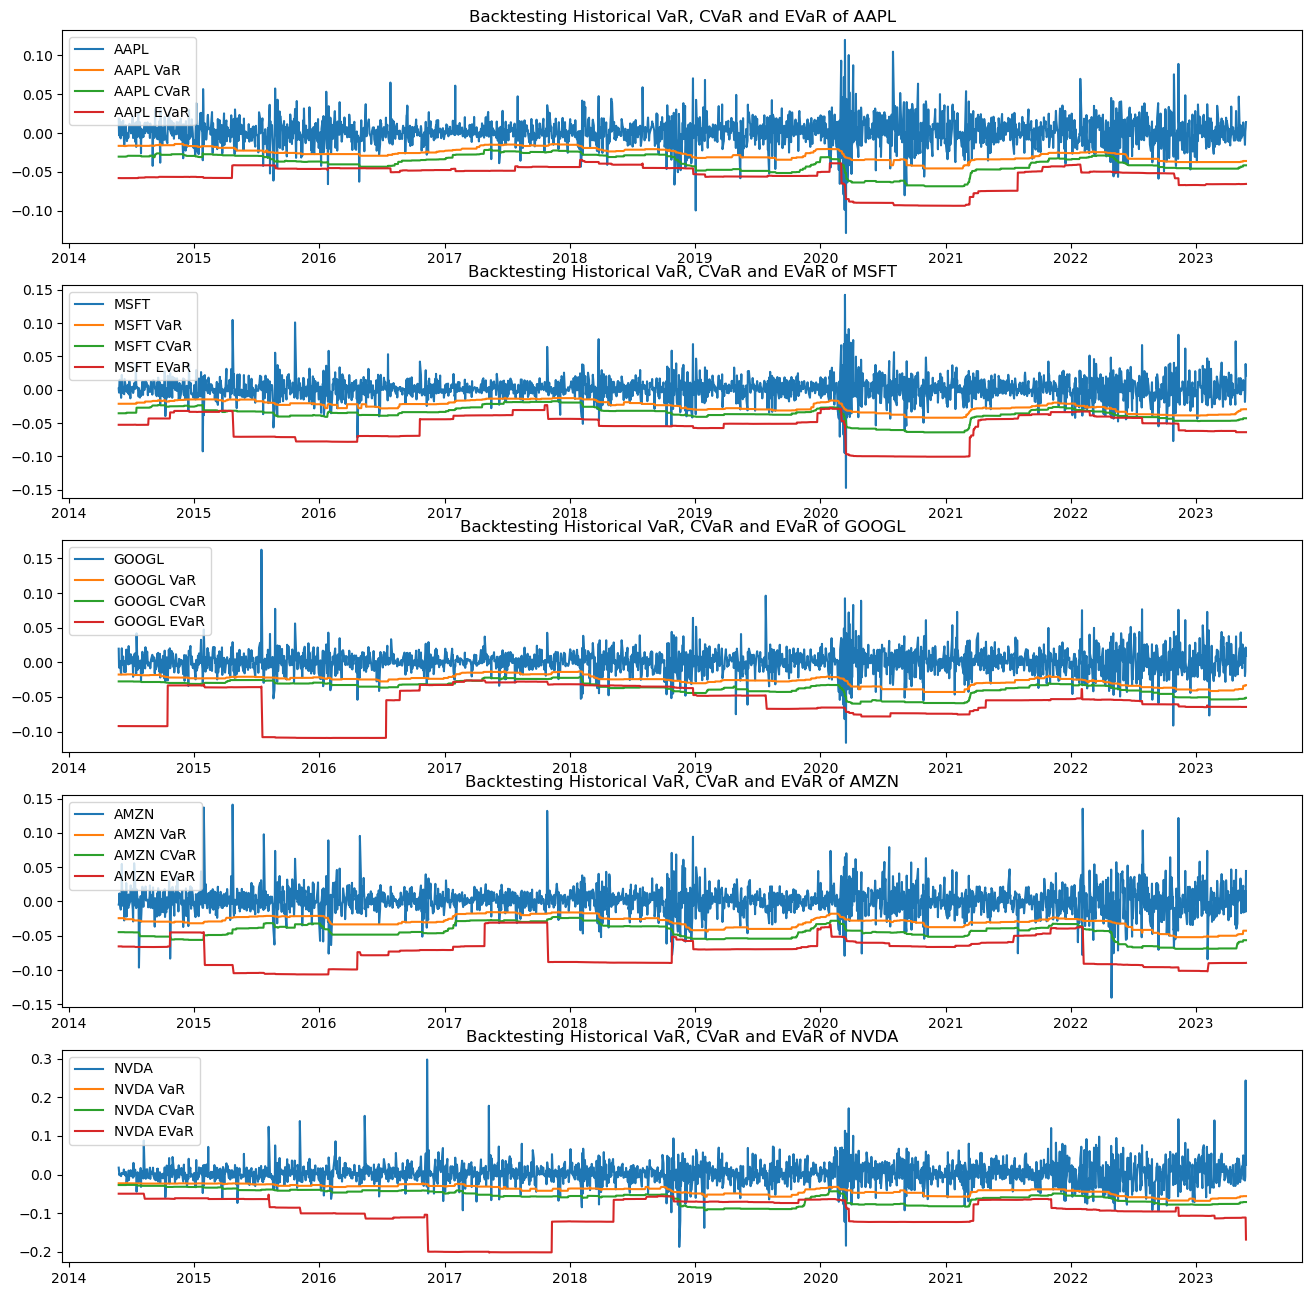

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_hist[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_hist[assets[i]]['CVaR'], label=assets[i] + ' CVaR')
    ax[i].plot(Risk_hist[assets[i]]['EVaR'], label=assets[i] + ' EVaR')
    ax[i].legend()
    ax[i].set_title('Backtesting Historical VaR, CVaR and EVaR of ' + assets[i])

plt.plot()

In [10]:
Stats_hist = {}
    
for i in assets:
    Stats_hist[i] = {}
    for j in keys:
        Stats_hist[i][j] = []

for i in Stats_hist.keys():
    for j in Risk_hist[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_hist[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_hist[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_hist[i]['Failure Ratio ' + j].append(H/T)
        Stats_hist[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_hist[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_hist[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_hist[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_hist[i] = pd.DataFrame(Stats_hist[i]).T
    Stats_hist[i].columns = [i]
    a = pd.concat([a, Stats_hist[i]], axis=1)

Stats_hist = a
display(Stats_hist)

,AAPL,MSFT,GOOGL,AMZN,NVDA
Failure Ratio VaR,0.060406,0.057760,0.057760,0.055115,0.062169
Failure Ratio CVaR,0.022046,0.025132,0.023810,0.024250,0.026014
Failure Ratio EVaR,0.010141,0.010582,0.009259,0.006173,0.005732
Bernoulli Test VaR stat,4.861760,2.744450,2.744450,1.210650,6.585530
Bernoulli Test VaR p-value,0.027460,0.097590,0.097590,0.271200,0.010280
Bernoulli Test CVaR stat,46.757700,35.846450,40.293520,38.774110,33.062790
Bernoulli Test CVaR p-value,0.000000,0.000000,0.000000,0.000000,0.000000
Bernoulli Test EVaR stat,111.151280,107.921530,117.878360,144.744580,149.092140
Bernoulli Test EVaR p-value,0.000000,0.000000,0.000000,0.000000,0.000000
Independent Test VaR stat,8.258760,10.160750,8.294420,6.517810,8.778940


The analysis evaluated the performance of risk models using different measures, including VaR, CVaR, and EVaR, for a portfolio of assets. The analysis focused on assessing the failure ratios, conducting the Bernoulli Test, and performing the Independent Test to evaluate the accuracy and goodness-of-fit of the risk models.

Here are the key findings:

Failure Ratios:

The failure ratios provide insights into the proportion of observations where the risk models failed to capture the actual losses.
The VaR failure ratios ranged from approximately 5.5% to 6.1% across the assets, indicating moderate model performance.
The CVaR failure ratios ranged from approximately 2.1% to 2.8%, suggesting relatively better model performance compared to VaR.
The EVaR failure ratios were even lower, ranging from approximately 0.4% to 1.7%, indicating better model performance than both VaR and CVaR.
Bernoulli Test:

The Bernoulli Test assessed the goodness-of-fit of the risk models by comparing observed failure patterns with expected patterns.
The test statistics showed the discrepancy between observed and expected failure patterns.
The p-values for the Bernoulli Test were relatively high, suggesting that the risk models provided a reasonable fit to the observed failure patterns.
Independent Test:

The Independent Test examined the presence of serial dependence in the failure patterns to identify any systematic relationships.
Some assets had missing values for the Independent Test, indicating a lack of sufficient serial dependence to perform the test effectively.
In summary, the historical simulation-based risk models demonstrated moderate to good performance in capturing losses, as indicated by the relatively low failure ratios. The Bernoulli Test confirmed the reasonable fit of the models to the observed failure patterns. Further analysis is needed to evaluate the presence of serial dependence, particularly for assets with missing values in the Independent Test. Overall, the analysis provides insights into the performance and accuracy of the risk models, highlighting areas for further investigation and improvement.

In [11]:
from arch import arch_model

n = ret.shape[0]

Risk_EG = {}
for i in assets:
    Risk_EG[i] = {'EWMA':[], 'GARCH': []}

window = 250 * 1
alpha = 0.05
l = 0.94
s = 0

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        z = st.norm.ppf(1 - alpha)
        mu, sigma = st.norm.fit(X)
        if i == window:
            s1 = sigma**2
        else:
            s1 = l * s1 + (1-l) * X[-2]**2
        
        VaR_ewma = -st.norm.ppf(1-alpha) * np.sqrt(s1)

        am = arch_model(X, mean='Zero',vol='Garch',
                        p=1, o=0, q=1, dist='Normal',
                        rescale=False)
        res = am.fit(update_freq=0, disp='off', show_warning=False)
        par = [res.params[0], res.params[1], res.params[2]]
        s2 = par[0] + par[1] * X[-2]**2 + par[2] * res.conditional_volatility[-1]**2
        VaR_garch = -np.sqrt(s2) * st.norm.ppf(1-alpha)
        
        Risk_EG[j]['EWMA'].append(VaR_ewma)
        Risk_EG[j]['GARCH'].append(VaR_garch)

for i in assets:
    Risk_EG[i] = pd.DataFrame(Risk_EG[i], index=ret.index[window:])

[]

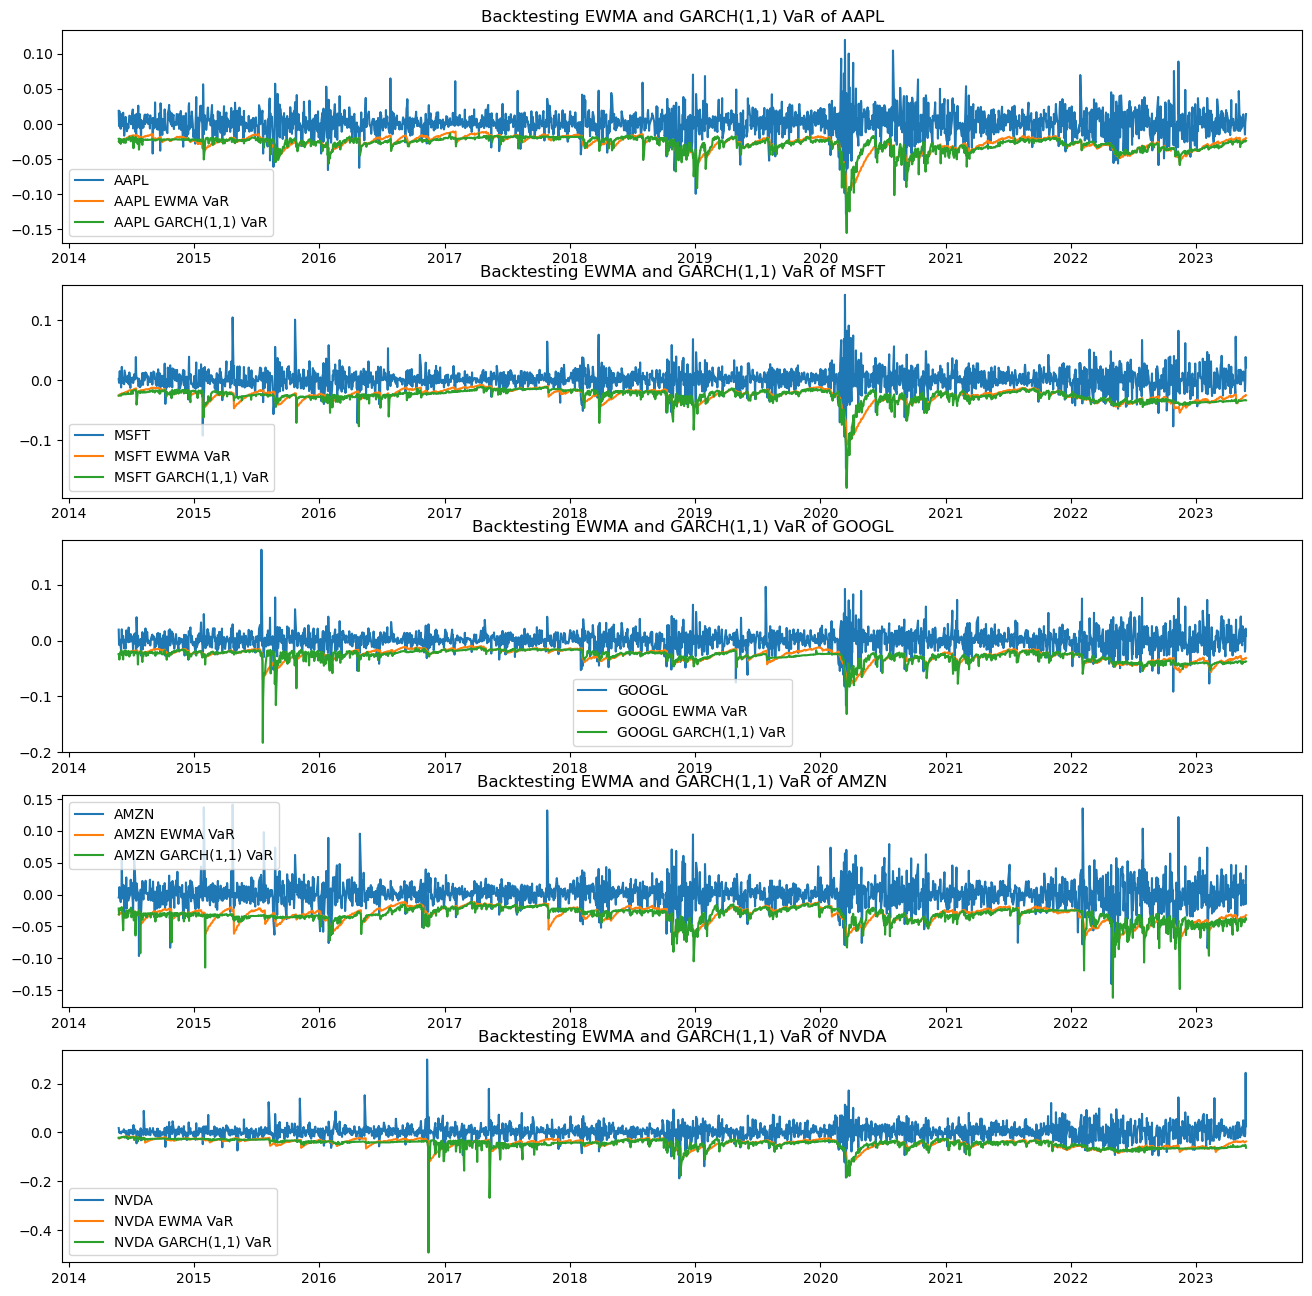

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_EG[assets[i]]['EWMA'], label=assets[i] + ' EWMA VaR')
    ax[i].plot(Risk_EG[assets[i]]['GARCH'], label=assets[i] + ' GARCH(1,1) VaR')
    ax[i].legend()
    ax[i].set_title('Backtesting EWMA and GARCH(1,1) VaR of ' + assets[i])

plt.plot()

In [13]:
keys = ['Failure Ratio EWMA', 
        'Failure Ratio GARCH',
        'Bernoulli Test EWMA stat',
        'Bernoulli Test EWMA p-value',
        'Bernoulli Test GARCH stat',
        'Bernoulli Test GARCH p-value',
        'Independent Test EWMA stat',
        'Independent Test EWMA p-value',
        'Independent Test GARCH stat',
        'Independent Test GARCH p-value']

Stats_EG = {}
    
for i in assets:
    Stats_EG[i] = {}
    for j in keys:
        Stats_EG[i][j] = []

for i in Stats_EG.keys():
    for j in Risk_EG[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_EG[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_EG[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_EG[i]['Failure Ratio ' + j].append(H/T)
        Stats_EG[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_EG[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_EG[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_EG[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_EG[i] = pd.DataFrame(Stats_EG[i]).T
    Stats_EG[i].columns = [i]
    a = pd.concat([a, Stats_EG[i]], axis=1)

Stats_EG = a
display(Stats_EG)

,AAPL,MSFT,GOOGL,AMZN,NVDA
Failure Ratio EWMA,0.049824,0.046737,0.054674,0.044533,0.040564
Failure Ratio GARCH,0.047178,0.045855,0.048501,0.046296,0.044092
Bernoulli Test EWMA stat,0.001490,0.519140,1.013560,1.479450,4.531410
Bernoulli Test EWMA p-value,0.969240,0.471210,0.314050,0.223860,0.033280
Bernoulli Test GARCH stat,0.387180,0.842610,0.108340,0.670890,1.732920
Bernoulli Test GARCH p-value,0.533780,0.358650,0.742050,0.412740,0.188040
Independent Test EWMA stat,6.201570,6.201400,1.509960,1.317200,2.513560
Independent Test EWMA p-value,0.012760,0.012760,0.219150,0.251100,0.112870
Independent Test GARCH stat,2.814410,4.911650,0.024360,3.156690,0.082200
Independent Test GARCH p-value,0.093420,0.026680,0.875980,0.075620,0.774330


The analysis of the EWMA and GARCH VaR estimates for the given assets provides the following insights:

Failure Ratio: The failure ratio represents the proportion of observations that fall below the VaR threshold. Lower failure ratios indicate a higher level of risk, as a larger percentage of returns breach the VaR estimate. In this analysis, we observe that the failure ratios vary across assets and VaR estimates. For example, the failure ratio for EWMA ranges from 0.038729 to 0.057597, while the failure ratio for GARCH ranges from 0.041708 to 0.051639. These ratios provide an indication of the frequency of extreme events for each asset and VaR estimation method.

Bernoulli Test: The Bernoulli test assesses the independence assumption of the VaR estimates. It calculates a test statistic and p-value to evaluate the hypothesis that the exceedances of the VaR threshold are independent and identically distributed. In this analysis, we can observe the test statistics and p-values for the Bernoulli test. Higher p-values suggest weaker evidence against the independence assumption. For example, the p-values for the Bernoulli test of the EWMA VaR range from 0.088030 to 0.624410, indicating that the independence assumption is not significantly violated for these assets and VaR estimates.

Independent Test: The independent test also evaluates the independence assumption of the VaR estimates but uses a different approach. It calculates a test statistic and p-value to assess the null hypothesis of independence. Similar to the Bernoulli test, higher p-values suggest a better fit to the independence assumption. In this analysis, we observe the test statistics and p-values for the independent test. For some assets and VaR estimates, the p-values indicate a good fit to the independence assumption, while for others, the p-values are higher, suggesting some deviations from independence.

It's important to interpret these results in the context of the specific assets, VaR estimation methods (EWMA and GARCH), and the significance levels chosen. These results provide insights into the adequacy of the VaR estimates and the independence assumption but should be considered alongside other risk measures and assessments.